# Reinforcement Learning Project

## Setup

To be able to run this notebook properly please make sure to install the pettingzoo package and dependencies. This can be done by running the following command

`pip install pettingzoo[mpe]`

### Imports

In [1]:
from pettingzoo.mpe import simple_world_comm_v2
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint
from matplotlib import pyplot as plt
import time
import datetime

### Environment Initialisation

In [2]:
MAX_CYCLES = 50
# Keep as a multiple of 10
NUM_OF_EPISODES = 500
MEANING_OF_LIFE = 42
ENVIRONMENT_NAME = "simple_world_comm"

env = simple_world_comm_v2.env(num_good=2, num_adversaries=4, num_obstacles=1,
                num_food=2, max_cycles=MAX_CYCLES, num_forests=2, continuous_actions=False)



env.seed(seed=MEANING_OF_LIFE)
env.reset()
print(f"Agents: {env.agents}")
print()
agent_mapping = {k: v for v, k in enumerate(env.agents)}
inv_agent_map = {v: k for k, v in agent_mapping.items()}
NUM_OF_AGENTS = len(env.agents)


Agents: ['leadadversary_0', 'adversary_0', 'adversary_1', 'adversary_2', 'agent_0', 'agent_1']



### Policy Function

In [3]:
def random_policy(actions):
    return random.randint(0, actions-1)

### Inspection Functions

A collection of inspection functions to help minimise clutter in the training loop below.

In [4]:
def matching_agent_only(agent, desired_agent, function, function_args):
#     To use this function, pass the agent and desired agent as the first two arguments,
#     then pass the function reference and the arguments for the function as a tuple for the final argument.
    if agent == desired_agent:
        function(*function_args)


def print_agent_rewards(agent, reward):
    print(f"{agent}:{reward}")
    
def print_agent_state(agent, observation):
    print(f"{agent}: {observation}")
    
def print_iter_info(agent,observation,reward,done,info):
    print(f"Current Agent: {agent}")
    print(f"Obs: {observation}")
    print(f"Rew: {reward}")      
    print(f"Done: {done}")
    print(f"Info: {info}")

def get_current_step(env):
    return env.env.env.steps

def np_array_no_e(array):
    np.set_printoptions(suppress=True)
    print(array)
    np.set_printoptions(suppress=False)

### Running the environment

The `env.render(mode='human')` call will pop open a new window that shows the environment at each time step.

On my machine at least this window can only be closed while the cell is running but then freezes and is unable to be closed afterwards. In these cases restarting the kernel closed the window and any others which may have been opened due to running the cell multiple times.

Eventually running the cell enough times without restarting the kernal will cause the render call to throw an exception and not run. In this case just restart the kernal and it will begin working again.

In [5]:
class agent_stub:
    def __init__(self):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return random_policy(env.action_space(agent).n)
    
    def save_action_state(self, action, state):
        pass
    
    def save_memory(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass

    def update_target_network_weights(self):
        pass

In [6]:
class good_agent_stub:
    def __init__(self):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return 0
    
    def save_action_state(self, action, state):
        pass
    
    def save_memory(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass
    
    def update_target_network_weights(self):
        pass

In [7]:
class agent:
    
    def __init__(self, agent_name, state_size, epsilon=1, epsilon_min = 0.1, 
                 epsilon_decay = 0.975, batch_size=16, learning_decay_rate = 0.95,
                target_update_steps = 10, action_space=5, experience_replay = True):
        
        self.state_size = state_size
        self.action_space = 5
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.agent_name = agent_name
        self.history = []
        self.action_taken = None
        self.previous_state = None
        self.batch_size = batch_size
        self.gamma = learning_decay_rate
        self.target_update_steps = target_update_steps
        self.update_target_network_weights()
        self.replay_enabled = experience_replay
    
    def build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(self.state_size, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(self.action_space, activation="relu"))
        model.compile(loss=keras.losses.Huber(), 
                      optimizer = keras.optimizers.Adam(learning_rate=0.0005))
 
        return model
    
    def exploration_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = min(self.epsilon_min, self.epsilon*self.epsilon_decay)
            
    def save_model(self, agent_filename, target_filename):
        self.model.save(agent_filename+".h5")
        self.target_model.save(target_filename+".h5")
    
    def load_model(self, agent_filename, target_filename):
        self.model.load_weights(agent_filename)
        self.target_model.load_weights(target_filename)
        
    def policy(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        action_vals = self.predict(state)
        return np.argmax(action_vals[0])
    
    def save_action_state(self, action, state):
        self.action_taken = action
        self.previous_state = state
        
    def save_history(self, state, reward, done):
        if self.previous_state is None and self.action_taken is None:
            self.previous_state = state
            self.action_taken = 0
        self.history.append((self.previous_state, self.action_taken, reward, state, done))
    
    def get_history(self):
        return self.history
    
    def replay(self):
        if self.replay_enabled:
            if len(self.history) < self.batch_size:
                return
            sample_batch = random.sample(self.history, self.batch_size)
            targets = []
            states = []

            for state, action, reward, next_state, done in sample_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
                target_f = self.predict(state)
                target_f[0][action] = target
                targets.append(target_f[0])
                states.append(state)      
            
#             print(np.asarray(targets).shape)
#             print(np.asarray(states).shape)
            
            self.model.fit(np.asarray(states),np.asarray(targets), epochs=1, verbose=0, batch_size=self.batch_size)
        else:
#             print(self.history[-1])
            state, action, reward, next_state, done = self.history[-1]
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
            target_f = self.predict(state)
            target_f[0][action] = target
            state = np.reshape(state, (1,self.state_size))
            self.model.fit(state,target_f, epochs=1, verbose=0,)
        
        self.exploration_decay()
    
    def get_learning_steps(self):
        return self.learning_steps
    
    def predict(self, state):
#         print(f"Before Reshape: {state}")
        state = np.reshape(state, (1,self.state_size))
#         print(f"After Reshape: {state}")
        return self.model.predict(state)

    def target_predict(self, state):
        state = np.reshape(state, (1,self.state_size))
        return self.target_model.predict(state)

    def update_target_network_weights(self):
        self.target_model.set_weights(self.model.get_weights())

In [8]:
env.seed(seed=MEANING_OF_LIFE)
env.reset()
reward_array = np.zeros((NUM_OF_EPISODES,len(env.agents)))

cumulative_reward = np.zeros(len(env.agents))
i = 0
agent_models = {}

ten_percent_episodes = int(NUM_OF_EPISODES/10)
save_models = True


# Creates the models. Models are shared between multiple adversaries and agents so for the first one of
# each type it creates the models while subsequent agents get the reference to the model passed as their
# 'model'
for key in agent_mapping:
    if key == "leadadversary_0":
        agent_models[key] = agent(key, env.observation_space(key)._shape[0], 
                                  action_space=env.action_space("leadadversary_0").n)
    elif "adversary" in key:
        if key == "adversary_0":    
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["adversary_0"]
    elif "agent" in key:
        if "agent_0" == key:
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["agent_0"]

cycle_scores = np.zeros((len(env.agents), NUM_OF_EPISODES,MAX_CYCLES+1))
step = -1
episode_times = []  


for episode in range(NUM_OF_EPISODES):
    print(f"Episode {episode+1} out of {NUM_OF_EPISODES}")
    env.seed(seed=MEANING_OF_LIFE)
    env.reset()
    cumulative_reward.fill(0)
    if episode > 0:
        print(f"Time taken for previous episode: {time.time()-episode_start_time}")
    episode_start_time = time.time()
    
    for agent in env.agent_iter():
        step_time = time.time()    
        if step != get_current_step(env):
#             print(f"Step: {get_current_step(env)}/{MAX_CYCLES}")
            step = get_current_step(env)
#         print(agent)
        
        observation, reward, done, info = env.last()
        cumulative_reward[agent_mapping[agent]] += reward
        cycle_scores[agent_mapping[agent]][episode][step] = reward
        
        agent_models[agent].save_history(observation, reward, done)
        
        if agent in ["adversaryleader_0", "adversary_2", "agent_1"]:
            agent_models[agent].replay()
            if (step % agent_models[agent].target_update_steps) == 0:
                agent_models[agent].update_target_network_weights()

            if (episode % ten_percent_episodes == 0) and save_models:
                agent_models[agent].save_model(
                    ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_model",
                ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_target_model")

            
    #     Renders the environment for each step in a seperate window.        
#         env.render(mode='human')
    
    
    #     Steps the environment forward.
        if done:
            env.step(None)
            reward_array[episode,agent_mapping[agent]] = cumulative_reward[agent_mapping[agent]]
        else:
            action_to_take = agent_models[agent].policy(observation)
            env.step(action_to_take)
            agent_models[agent].save_action_state(action_to_take, observation)
        
#         print(f"Step Time: {time.time()-step_time}")
   

    episode_time = time.time()-episode_start_time
    episode_times.append(episode_time)
    print(f"Episode Time: {episode_time}")


KEY IS: leadadversary_0


2022-05-04 19:10:44.697052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:10:44.706071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:10:44.706297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 19:10:44.706907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

KEY IS: adversary_0
KEY IS: adversary_1
KEY IS: adversary_2
KEY IS: agent_0
KEY IS: agent_1
Episode 1 out of 500
Episode Time: 104.42464399337769
Episode 2 out of 500
Time taken for previous episode: 104.42517495155334
Episode Time: 111.8120801448822
Episode 3 out of 500
Time taken for previous episode: 111.81254243850708
Episode Time: 112.17572736740112
Episode 4 out of 500
Time taken for previous episode: 112.17621755599976
Episode Time: 111.761403799057
Episode 5 out of 500
Time taken for previous episode: 111.76180076599121
Episode Time: 111.22019934654236
Episode 6 out of 500
Time taken for previous episode: 111.22079372406006
Episode Time: 111.92251968383789
Episode 7 out of 500
Time taken for previous episode: 111.92300939559937
Episode Time: 111.72116374969482
Episode 8 out of 500
Time taken for previous episode: 111.72157669067383
Episode Time: 112.19827127456665
Episode 9 out of 500
Time taken for previous episode: 112.19861364364624
Episode Time: 112.52272272109985
Episode 1

Episode Time: 118.74955034255981
Episode 78 out of 500
Time taken for previous episode: 118.74990892410278
Episode Time: 117.64989233016968
Episode 79 out of 500
Time taken for previous episode: 117.65043091773987
Episode Time: 118.10841584205627
Episode 80 out of 500
Time taken for previous episode: 118.10879421234131
Episode Time: 118.76851654052734
Episode 81 out of 500
Time taken for previous episode: 118.76893782615662
Episode Time: 118.65998530387878
Episode 82 out of 500
Time taken for previous episode: 118.66041231155396
Episode Time: 118.94129943847656
Episode 83 out of 500
Time taken for previous episode: 118.94165778160095
Episode Time: 118.64048719406128
Episode 84 out of 500
Time taken for previous episode: 118.64105892181396
Episode Time: 118.15007877349854
Episode 85 out of 500
Time taken for previous episode: 118.15043139457703
Episode Time: 118.66731429100037
Episode 86 out of 500
Time taken for previous episode: 118.66768479347229
Episode Time: 118.79419898986816
Epis

Episode Time: 119.33017563819885
Episode 155 out of 500
Time taken for previous episode: 119.33075737953186
Episode Time: 119.13906025886536
Episode 156 out of 500
Time taken for previous episode: 119.13943672180176
Episode Time: 119.0175986289978
Episode 157 out of 500
Time taken for previous episode: 119.01807403564453
Episode Time: 118.44177198410034
Episode 158 out of 500
Time taken for previous episode: 118.44213843345642
Episode Time: 118.66727685928345
Episode 159 out of 500
Time taken for previous episode: 118.66770076751709
Episode Time: 119.71509265899658
Episode 160 out of 500
Time taken for previous episode: 119.71547985076904
Episode Time: 118.85033130645752
Episode 161 out of 500
Time taken for previous episode: 118.85069918632507
Episode Time: 118.80184769630432
Episode 162 out of 500
Time taken for previous episode: 118.80221366882324
Episode Time: 119.06882572174072
Episode 163 out of 500
Time taken for previous episode: 119.06937623023987
Episode Time: 119.18270754814

Episode Time: 119.69191217422485
Episode 232 out of 500
Time taken for previous episode: 119.69264960289001
Episode Time: 120.14172577857971
Episode 233 out of 500
Time taken for previous episode: 120.14213538169861
Episode Time: 119.94054746627808
Episode 234 out of 500
Time taken for previous episode: 119.94098496437073
Episode Time: 120.1209704875946
Episode 235 out of 500
Time taken for previous episode: 120.12134146690369
Episode Time: 119.40383315086365
Episode 236 out of 500
Time taken for previous episode: 119.40438103675842
Episode Time: 119.97088074684143
Episode 237 out of 500
Time taken for previous episode: 119.97163510322571
Episode Time: 120.36116886138916
Episode 238 out of 500
Time taken for previous episode: 120.3619110584259
Episode Time: 120.16864609718323
Episode 239 out of 500
Time taken for previous episode: 120.16900539398193
Episode Time: 119.86908555030823
Episode 240 out of 500
Time taken for previous episode: 119.86960649490356
Episode Time: 119.464422702789

Episode Time: 120.51513409614563
Episode 309 out of 500
Time taken for previous episode: 120.51558089256287
Episode Time: 120.66798639297485
Episode 310 out of 500
Time taken for previous episode: 120.66852903366089
Episode Time: 120.26351380348206
Episode 311 out of 500
Time taken for previous episode: 120.26395034790039
Episode Time: 120.56363272666931
Episode 312 out of 500
Time taken for previous episode: 120.56413292884827
Episode Time: 120.56734776496887
Episode 313 out of 500
Time taken for previous episode: 120.56770610809326
Episode Time: 120.9969642162323
Episode 314 out of 500
Time taken for previous episode: 120.99767923355103
Episode Time: 120.58855509757996
Episode 315 out of 500
Time taken for previous episode: 120.58900380134583
Episode Time: 120.83888292312622
Episode 316 out of 500
Time taken for previous episode: 120.83943128585815
Episode Time: 120.89206194877625
Episode 317 out of 500
Time taken for previous episode: 120.89251780509949
Episode Time: 120.70050787925

Episode Time: 123.0921950340271
Episode 386 out of 500
Time taken for previous episode: 123.09299540519714
Episode Time: 121.69686079025269
Episode 387 out of 500
Time taken for previous episode: 121.69727802276611
Episode Time: 121.69846510887146
Episode 388 out of 500
Time taken for previous episode: 121.69901466369629
Episode Time: 121.3804223537445
Episode 389 out of 500
Time taken for previous episode: 121.38081169128418
Episode Time: 121.03730320930481
Episode 390 out of 500
Time taken for previous episode: 121.03790283203125
Episode Time: 121.01336574554443
Episode 391 out of 500
Time taken for previous episode: 121.01380705833435
Episode Time: 120.68920516967773
Episode 392 out of 500
Time taken for previous episode: 120.68963813781738
Episode Time: 121.216712474823
Episode 393 out of 500
Time taken for previous episode: 121.21706676483154
Episode Time: 120.57838010787964
Episode 394 out of 500
Time taken for previous episode: 120.57877373695374
Episode Time: 121.62777042388916

Episode Time: 122.88991737365723
Episode 463 out of 500
Time taken for previous episode: 122.89045882225037
Episode Time: 122.43687391281128
Episode 464 out of 500
Time taken for previous episode: 122.43724536895752
Episode Time: 122.88931131362915
Episode 465 out of 500
Time taken for previous episode: 122.88992285728455
Episode Time: 122.43812942504883
Episode 466 out of 500
Time taken for previous episode: 122.43878293037415
Episode Time: 122.41411638259888
Episode 467 out of 500
Time taken for previous episode: 122.41450572013855
Episode Time: 122.2228684425354
Episode 468 out of 500
Time taken for previous episode: 122.22325491905212
Episode Time: 123.18779301643372
Episode 469 out of 500
Time taken for previous episode: 123.18823289871216
Episode Time: 122.9366979598999
Episode 470 out of 500
Time taken for previous episode: 122.93717980384827
Episode Time: 122.10049962997437
Episode 471 out of 500
Time taken for previous episode: 122.10092282295227
Episode Time: 122.557747840881

In [9]:
# Closs the render window.
# env.close()

### Print Reward Array

In [20]:
np_array_no_e(reward_array)

x = 1

with open(f"{ENVIRONMENT_NAME}_DQN_{NUM_OF_EPISODES}ep.csv", "w+") as f:
    f.write("episode,adversary_0,agent_0\n")
    for j, i in enumerate(reward_array):
        f.write(f"{x}, {i[0]},{i[1]}, {i[2]},{i[3]},{i[4]},{i[5]}\n")
        x += 1

[[  -0.80281264   -2.26367163    3.77568439   -4.87632715 -434.04811088
  -694.19861978]
 [  -6.29076226   -5.5871003    -6.68970091   -7.50292449   -3.48947699
    -2.21718225]
 [  -7.32233233   -4.65765696   -2.81632174   -4.89709053  -96.62690251
    -2.7669076 ]
 ...
 [  -6.40984002   -5.19169215   -2.56111915   -4.65601415 -104.36577657
   -10.53927443]
 [  -6.57184637   -4.99935037   -2.95402681   -4.20825493   -3.34303635
    -2.76776264]
 [  -6.87513894   -5.7898116    -1.78294661   -4.80715975   -3.29178811
    -3.04891606]]


In [11]:
# np_array_no_e(cycle_scores[0])
# print()
# print()
# print()
# np_array_no_e(cycle_scores[1])
# np_array_no_e(cycle_scores[1].sum(axis=1))

In [12]:
print(str(datetime.timedelta(seconds=np.mean(episode_times))))

0:01:59.749035


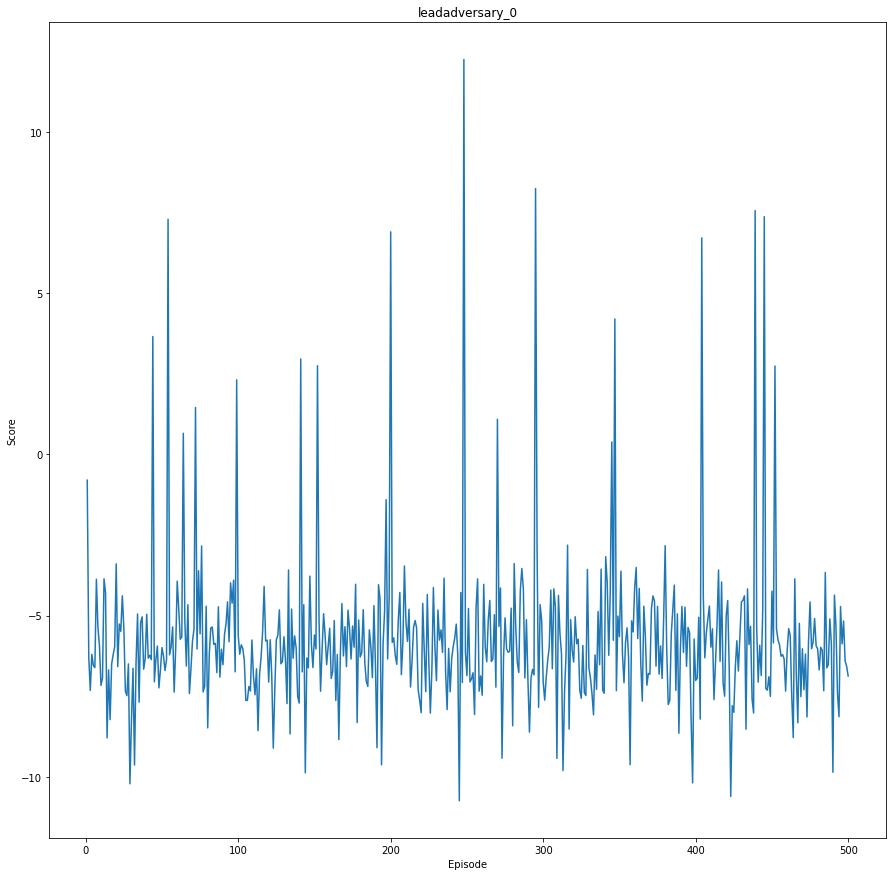

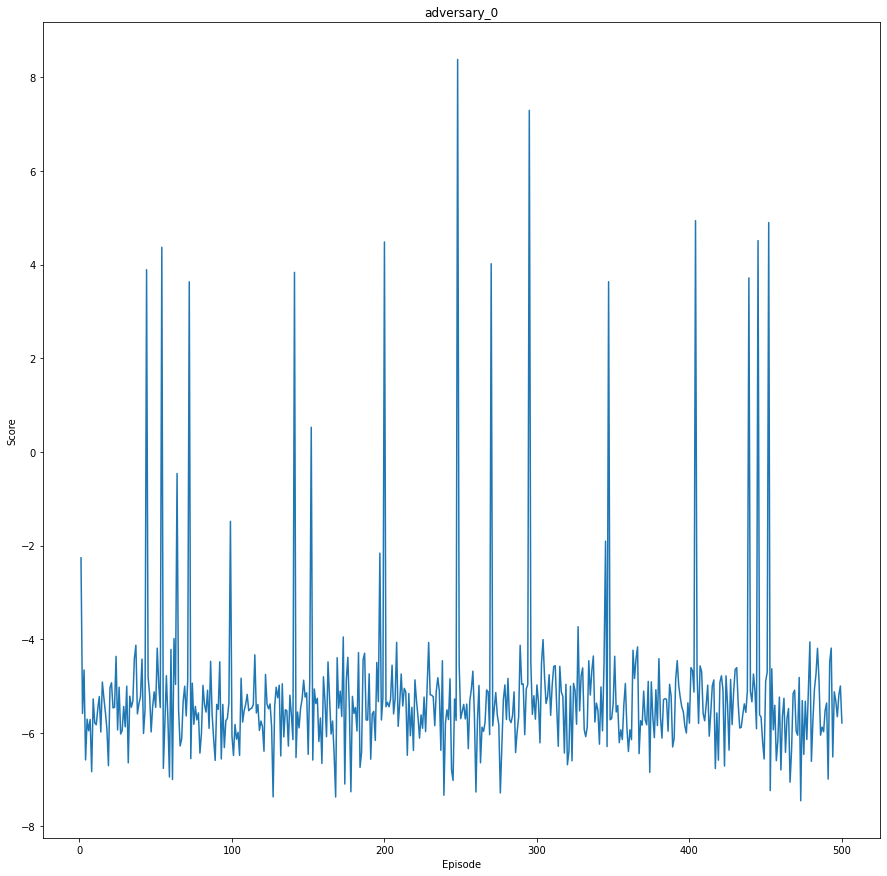

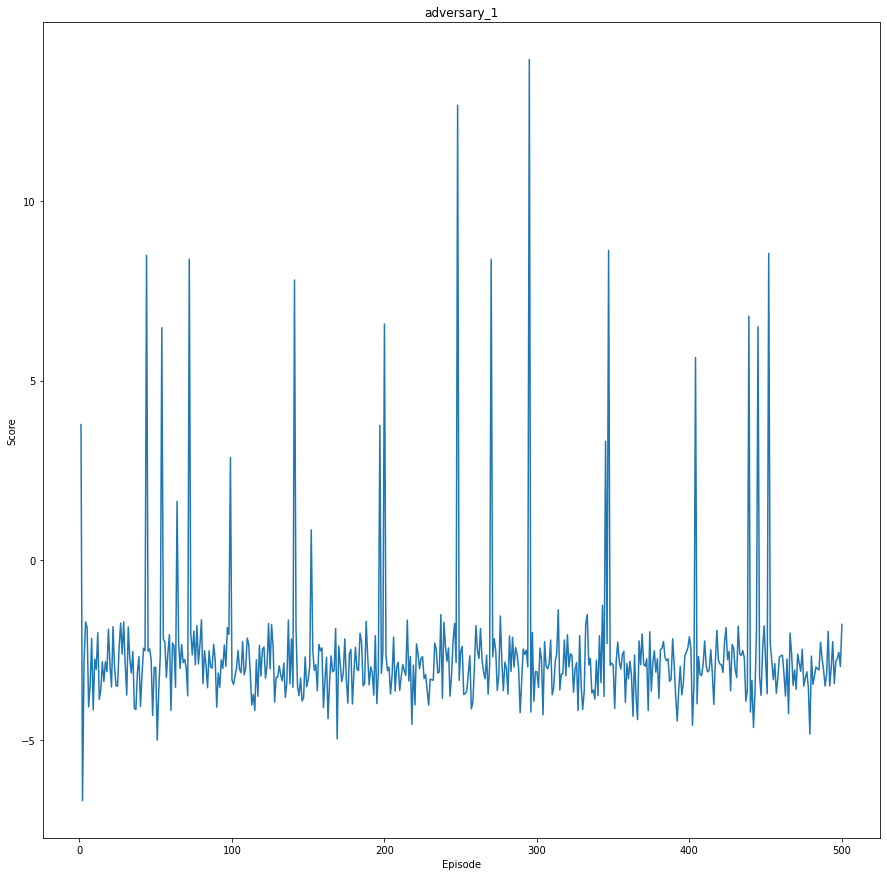

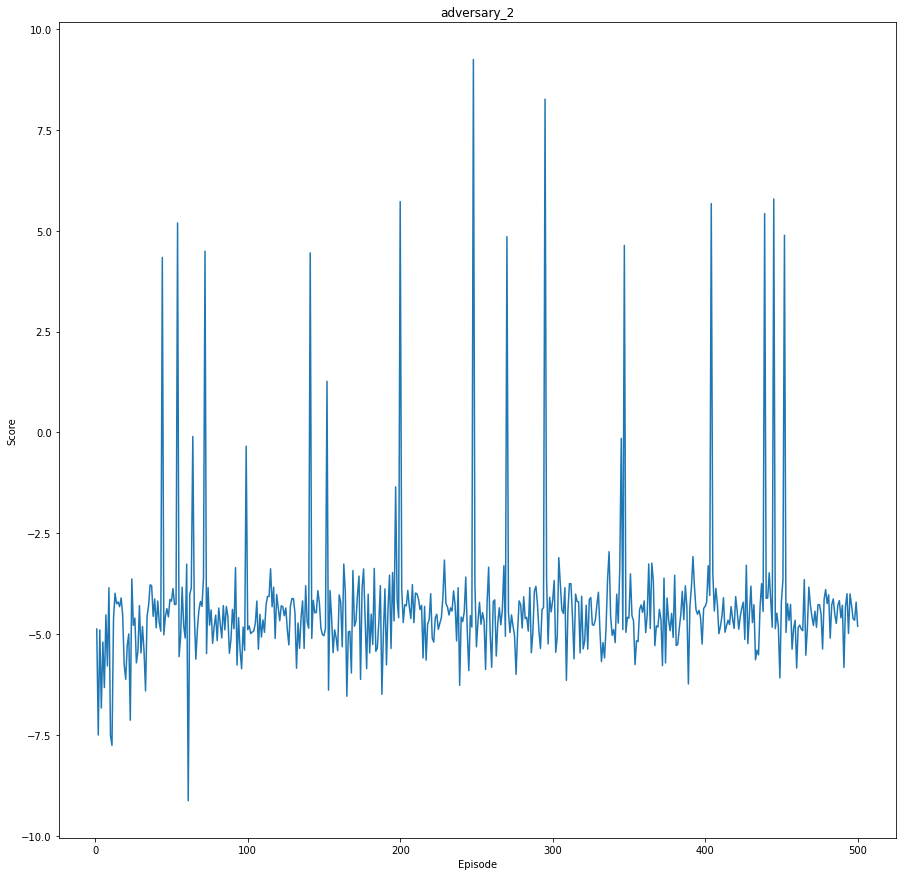

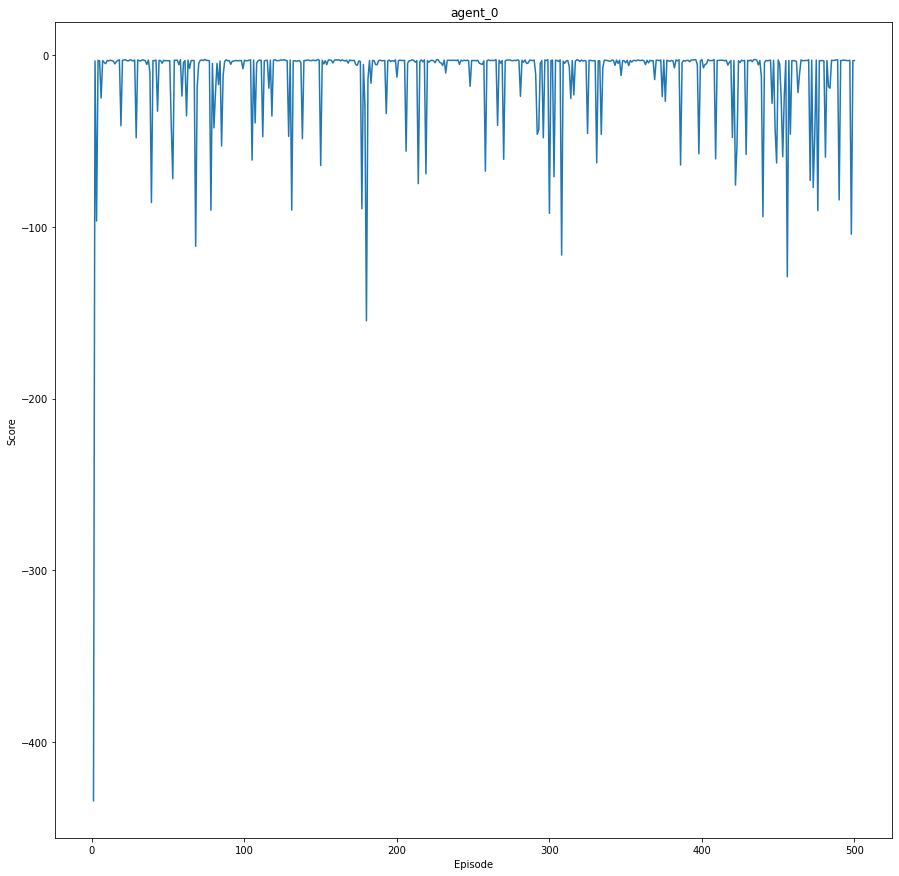

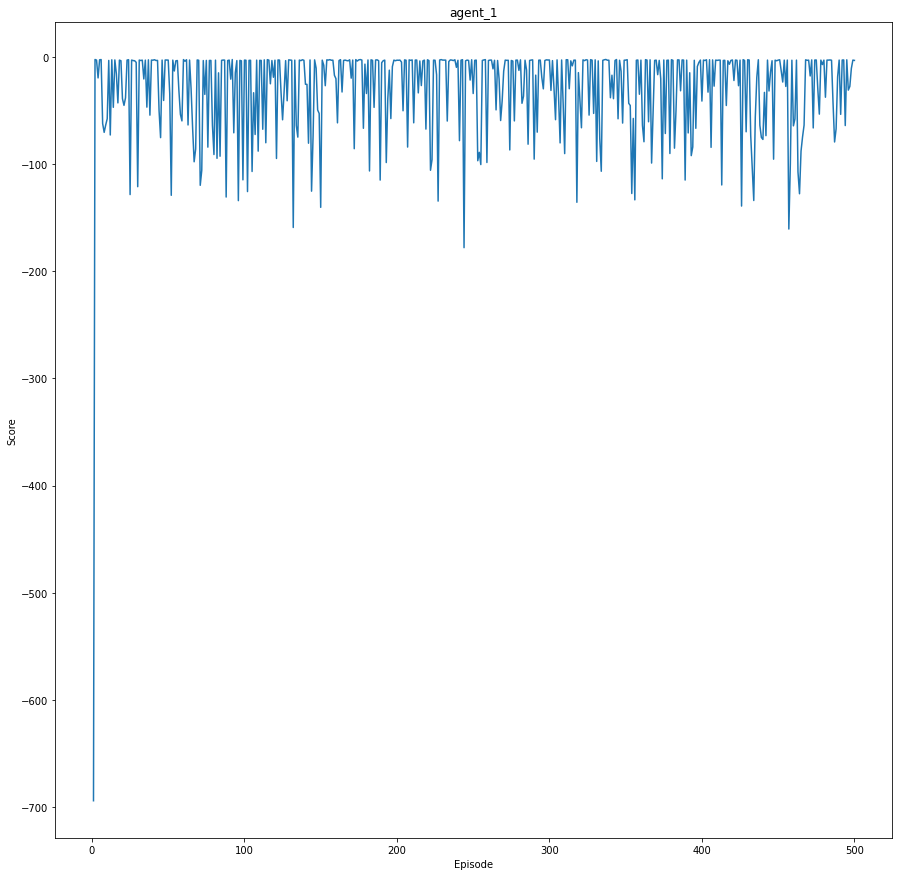

In [13]:
for i in range(0,NUM_OF_AGENTS):
    plt.figure(figsize=(15,15))
    plt.plot(range(1,NUM_OF_EPISODES+1), reward_array[:,i])
    plt.title(inv_agent_map[i])
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.savefig(f"{ENVIRONMENT_NAME}_{inv_agent_map[i]}_learning_"+str(NUM_OF_EPISODES)+"_episodes.png")
    plt.show()

In [14]:
print(agent_models)

{'leadadversary_0': <__main__.agent object at 0x7f86dc1e3e20>, 'adversary_0': <__main__.agent object at 0x7f86d82245e0>, 'adversary_1': <__main__.agent object at 0x7f86d82245e0>, 'adversary_2': <__main__.agent object at 0x7f86d82245e0>, 'agent_0': <__main__.agent object at 0x7f86d81e4460>, 'agent_1': <__main__.agent object at 0x7f86d81e4460>}


In [15]:
pprint(vars(env.env.env))

{'_agent_selector': <pettingzoo.utils.agent_selector.agent_selector object at 0x7f87740adc10>,
 '_cumulative_rewards': {},
 '_index_map': {'adversary_0': 1,
                'adversary_1': 2,
                'adversary_2': 3,
                'agent_0': 4,
                'agent_1': 5,
                'leadadversary_0': 0},
 '_skip_agent_selection': None,
 'action_spaces': {'adversary_0': Discrete(5),
                   'adversary_1': Discrete(5),
                   'adversary_2': Discrete(5),
                   'agent_0': Discrete(5),
                   'agent_1': Discrete(5),
                   'leadadversary_0': Discrete(20)},
 'agent_selection': 'leadadversary_0',
 'agents': [],
 'continuous_actions': False,
 'current_actions': [1, 0, 0, 0, 0, 2],
 'dones': {},
 'infos': {},
 'local_ratio': None,
 'max_cycles': 50,
 'metadata': {'is_parallelizable': True,
              'name': 'simple_world_comm_v2',
              'render_fps': 10,
              'render_modes': ['human', 'rgb_array']

In [16]:
agent_models["adversary_0"].save_model(
    ENVIRONMENT_NAME+"_adversary_0_"+str(NUM_OF_EPISODES)+"_ep_final_model", 
    ENVIRONMENT_NAME+"_adversary_0_"+str(NUM_OF_EPISODES)+"_final_target_model")

In [17]:
agent_models["agent_0"].save_model(
    ENVIRONMENT_NAME+"_agent_0_"+str(NUM_OF_EPISODES)+"_final_model", 
    ENVIRONMENT_NAME+"_agent_0_"+str(NUM_OF_EPISODES)+"_final_target_model")